# Adaption of OLA 6 for project

Aric Moilanen 

## Problem 1

In [215]:
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from IPython.display import display

In [216]:
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions

In [258]:
def grab_image(img_path_base, index, numImages):
    #Desired image dimension (image will be square ie # by # pixels)
    imageDim = 250
    
    if (index<10):
        img_path = img_path_base+"000"+str(index)+"_model.png"
    elif (index<100 and index >=10):
        img_path = img_path_base+"00"+str(index)+"_model.png"
    elif (index<1000 and index>=100):
        img_path = img_path_base+"0"+str(index)+"_model.png"
    elif (index<10000 and index>=1000):
        img_path = img_path_base+str(index)+"_model.png"
        
    img = image.load_img(img_path, target_size=(imageDim, imageDim), color_mode = "grayscale")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


numImages = 600
X = np.concatenate([grab_image('/home/atm4w/Project/Data/miscImgs/',i, numImages) for i in range(numImages)]) 
X /= 255.0

X.shape

(600, 250, 250, 1)

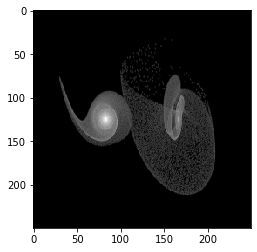

In [259]:
plt.imshow(image.array_to_img(X[45,:,:,:]), cmap='Greys_r')
plt.show()

In [260]:
Y = np.loadtxt('/home/atm4w/Project/Data/miscImgs/scores/humanScores.txt')
display(Y.shape)
display(Y[0:10])

(1294,)

array([0.945946, 0.941176, 0.918919, 0.916667, 0.916667, 0.914286,
       0.914286, 0.911765, 0.891892, 0.885714])

In [261]:
quartileRankings = np.zeros(Y.size)
scores=open('/home/atm4w/Project/Data/miscImgs/scores/humanScores.txt',"r")
lines=scores.readlines()

i=0
for x in lines:
    if ( float(x) <=1.00 and float(x) > 0.75):
        quartileRankings[i] = 0
    elif ( float(x) <=0.75 and float(x) > 0.5):
        quartileRankings[i] = 1
    elif ( float(x) <=0.5 and float(x) > 0.25):
        quartileRankings[i] = 2
    elif ( float(x) <=0.25 and float(x) >= 0.0):
        quartileRankings[i] = 3
        
    i+=1

scores.close()

Y=Y[0:numImages]
quartileRankings = quartileRankings[0:numImages]

display(Y.shape)
display(quartileRankings.shape)

(600,)

(600,)

In [268]:
p = np.random.permutation(len(X))
Xshuffled = X[p]
Yshuffled = Y[p]
quartileShuffled = quartileRankings[p]

display(Xshuffled.shape)
display(Yshuffled.shape)
display(quartileShuffled.shape)

(600, 250, 250, 1)

(600,)

(600,)

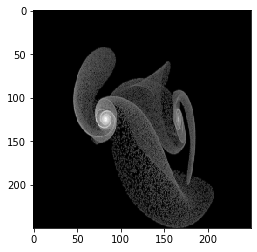

In [269]:
plt.imshow(image.array_to_img(Xshuffled[0,:,:,:]), cmap='Greys_r')
plt.show()

In [270]:
display(Yshuffled[0])
display(quartileShuffled[0])

0.371429

2.0

In [271]:
quartileShuffled = keras.utils.to_categorical(quartileShuffled, 4)
quartileShuffled.shape

(600, 4)

In [272]:
display(quartileShuffled[0, : ])
display(Yshuffled[0])

array([0., 0., 1., 0.], dtype=float32)

0.371429

In [273]:
x_train = Xshuffled[0:(round(numImages*.85)),:,:]
quartile_train = quartileShuffled[0:(round(numImages*.85)), :]
x_test = Xshuffled[(round(numImages*.85)): , : , :]
quartile_test = quartileShuffled[(round(numImages*.85)):, :]

display(x_train.shape)
display(quartile_train.shape)
display(x_test.shape)
display(quartile_test.shape)

(510, 250, 250, 1)

(510, 4)

(90, 250, 250, 1)

(90, 4)

In [274]:
model = keras.Sequential()
# Note the input size (there is only one channel - intensity)
# these images... if you are using color images, your would
# need to set the last dimension of the input_shape to -3-
# above and this would carry over into this cell...
model.add(keras.layers.Conv2D(16, kernel_size=(4, 4),
                                activation='relu',
                                input_shape=[x_train.shape[1],
                                x_train.shape[2],
                                x_train.shape[3]]))

#model.add(keras.layers.Conv2D(128, (8, 8), activation='relu'))
#model.add(keras.layers.MaxPooling2D(pool_size=(8, 8)))
#model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(64, activation='relu'))
#model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(quartile_train.shape[1], activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.nadam(learning_rate=0.0001),
                metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 247, 247, 16)      272       
_________________________________________________________________
flatten_16 (Flatten)         (None, 976144)            0         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 3904580   
Total params: 3,904,852
Trainable params: 3,904,852
Non-trainable params: 0
_________________________________________________________________


In [275]:
batch_size = 6
epochs = 10
history = model.fit(x_train, quartile_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split = 0.2)

Train on 408 samples, validate on 102 samples
Epoch 1/10
408/408 [==============================] - 6s 16ms/step - loss: 1.0996 - accuracy: 0.6152 - val_loss: 1.2047 - val_accuracy: 0.5196
Epoch 2/10
408/408 [==============================] - 6s 15ms/step - loss: 1.0492 - accuracy: 0.6250 - val_loss: 1.2128 - val_accuracy: 0.5196
Epoch 3/10
408/408 [==============================] - 6s 14ms/step - loss: 1.0359 - accuracy: 0.6250 - val_loss: 1.2055 - val_accuracy: 0.5196
Epoch 4/10
408/408 [==============================] - 6s 15ms/step - loss: 1.0313 - accuracy: 0.6250 - val_loss: 1.1721 - val_accuracy: 0.5196
Epoch 5/10
408/408 [==============================] - 6s 15ms/step - loss: 1.0155 - accuracy: 0.6250 - val_loss: 1.1608 - val_accuracy: 0.5196
Epoch 6/10
408/408 [==============================] - 6s 15ms/step - loss: 0.9972 - accuracy: 0.6250 - val_loss: 1.1570 - val_accuracy: 0.5196
Epoch 7/10
408/408 [==============================] - 6s 15ms/step - loss: 0.9740 - accuracy: 0.

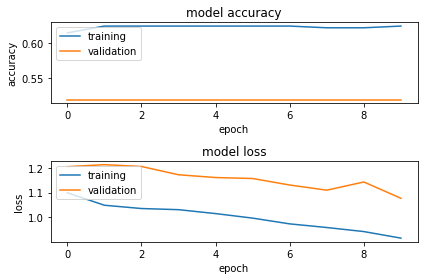

In [276]:
plt.figure()
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.tight_layout()
plt.show()